### Importing necessary packages

In [1]:
# utilities
import re #regex
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer 

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

### Data Preparation

In [2]:
df = pd.read_csv('./data/text.csv')

In [3]:
df

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [4]:
#filtered_df = df[df['label'].isin([0, 1, 3, 4])]
# Create a mapping to reallocate the labels
#label_mapping = {0: 0, 1: 1, 3: 2, 4: 3}  # sadness -> 0, joy -> 1, anger -> 2, fear -> 3
#filtered_df['label'] = filtered_df['label'].map(label_mapping)
#print(filtered_df)

        Unnamed: 0                                               text  label
0                0      i just feel really helpless and heavy hearted      3
1                1  ive enjoyed being able to slouch about relax a...      0
2                2  i gave up my internship with the dmrg and am f...      3
3                3                         i dont know i feel so lost      0
4                4  i am a kindergarten teacher and i am thoroughl...      3
...            ...                                                ...    ...
416801      416801  i don t even feel like i fully resolved it but...      1
416802      416802  i feel like i have been neglecting you my fait...      1
416803      416803  i cry and feel a sense of loss when my patient...      1
416805      416805  i began to realize that when i was feeling agi...      2
416807      416807  i feel that becuase of the tyranical nature of...      2

[367283 rows x 3 columns]


C:\Users\Nivetha\AppData\Local\Temp\ipykernel_5368\189390832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].map(label_mapping)


### Exploratory Data Analysis

In [4]:
print(df.head(5))

   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4


In [5]:
print(f"Length of dataset is {len(df)}")

Length of dataset is 416809


In [6]:
df.shape

(416809, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [8]:
df.isna().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

[Text(0, 0, 'Sadness'),
 Text(1, 0, 'Joy'),
 Text(2, 0, 'Love'),
 Text(3, 0, 'Anger'),
 Text(4, 0, 'Fear'),
 Text(5, 0, 'Surprise')]

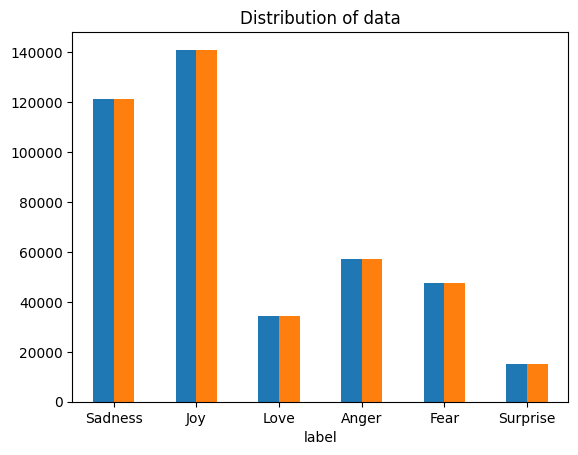

In [9]:
# Plotting the distribution for dataset.
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'], rotation=0)

In [11]:
df['label'].unique()

array([4, 0, 2, 1, 5, 3], dtype=int64)

### Balancing the dataset

In [12]:
# Group the data by label
grouped = filtered_df.groupby('label')

# Find the minimum number of samples among all labels
min_samples = grouped.size().min()

# Balance the dataset by randomly sampling 'min_samples' from each group
balanced_data = grouped.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

# Display the balanced dataset
print(balanced_data['label'].value_counts())

label
0    47712
1    47712
2    47712
3    47712
Name: count, dtype: int64


In [13]:
balanced_data

,Unnamed: 0,text,label
0,259171,i mean i dont mind when people dont like my fa...,0
1,90274,im not qualified to do just makes me feel wort...,0
2,254900,i don t feel i don t feel blank or numb,0
3,159398,i spent so much time feeling victimized becaus...,0
4,402046,i have gotten the feeling that i am unwelcome,0
...,...,...,...
190843,312370,i am feeling a bit overwhelmed by what i have ...,3
190844,314505,i mean i can walk but i feel so shy,3
190845,370114,i wouldn t be feeling so vulnerable,3
190846,4697,i wish gervase would have piped down so id fee...,3


In [14]:
balanced_data.shape

(190848, 3)

### Text Preprocessing

In [12]:
data=df[['text','label']]
data.tail(5)

,text,label
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3
416808,i think that after i had spent some time inves...,5


In [13]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('data/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()
    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)
    
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [14]:
data.loc[:, 'processed_text'] = data.text.apply(preprocess_apply)

In [15]:
data.head(10)

,text,label,processed_text
0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost,0,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...
5,i was beginning to feel quite disheartened,0,i was beginning to feel quite disheartened
6,i would think that whomever would be lucky eno...,2,i would think that whomever would be lucky eno...
7,i fear that they won t ever feel that deliciou...,1,i fear that they won t ever feel that deliciou...
8,im forever taking some time out to have a lie ...,5,im forever taking some time out to have a lie ...
9,i can still lose the weight without feeling de...,0,i can still lose the weight without feeling de...


In [16]:
count=0
for row in data.itertuples():
    print("Text:", row[1])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: i just feel really helpless and heavy hearted
Processed: i just feel really helpless and heavy hearted
Text: ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing
Processed: ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing
Text: i gave up my internship with the dmrg and am feeling distraught
Processed: i gave up my internship with the dmrg and am feeling distraught
Text: i dont know i feel so lost
Processed: i dont know i feel so lost
Text: i am a kindergarten teacher and i am thoroughly weary of my job after having taken the university entrance exam i suffered from anxiety for weeks as i did not want to carry on with m

### Splitting training and testing data

In [17]:
X = data['processed_text']  
y = data['label']  

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (333447,) (333447,)
Testing set shape: (83362,) (83362,)


### Tokenization

In [18]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download the stopwords dataset
nltk.download('stopwords')

In [ ]:
# Load the default NLTK stop words list
stop_words = set(stopwords.words('english'))

# Define gendered words you want to keep
gendered_words = {'he', 'she', 'him', 'her', 'man', 'woman', 'boy', 'girl', 'father', 'mother', 'son', 'daughter'}

# Remove gendered words from the stop words list
stop_words = stop_words - gendered_words


In [19]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
     # Tokenization
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in stop_words and word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in cleaned_tokens]
          # Join tokens back into a single string
    return ' '.join(tokens)

# Apply preprocessing to training and test data
X_train = np.array([preprocess_text(text) for text in X_train])
X_test = np.array([preprocess_text(text) for text in X_test])
print('Text preprocessing completed.')

Text preprocessing completed.


In [20]:
tokenized_X_train = [text.split() for text in X_train]
print("Tokenized Texts (first 5 examples):", tokenized_X_train[:5])

Tokenized Texts (first 5 examples): [['ive', 'blabbed', 'on', 'enough', 'for', 'tonight', 'im', 'tired', 'and', 'ive', 'been', 'feeling', 'pretty', 'crappy', 'from', 'this', 'kentucky', 'weather'], ['i', 'woke', 'up', 'really', 'early', 'this', 'morning', 'and', 'drove', 'in', 'and', 'i', 'just', 'feel', 'ecstatic', 'about', 'everything', 'getting', 'your', 'photo', 'taken', 'people', 'wanting', 'you', 'to', 'wear', 'their', 'clothes', 'i', 'love', 'all', 'of', 'it'], ['i', 'feel', 'i', 'never', 'gave', 'myself', 'a', 'rest', 'day', 'after', 'the', 'megabrick', 'because', 'i', 'wa', 'feeling', 'stubborn', 'and', 'belligerent', 'and', 'my', 'leg', 'are', 'waay', 'tired', 'i', 'keep', 'pressing', 'on', 'with', 'the', 'scheduled', 'workout', 'ignoring', 'the', 'number', 'watch', 'for', 'the', 'most', 'part', 'and', 'trying', 'to', 'keep', 'disappointment', 'far', 'off', 'my', 'radar'], ['i', 'am', 'feeling', 'restless', 'teary', 'flat', 'sad', 'and', 'strange', 'today'], ['i', 'feel', 'li

In [21]:
# Define the word you want to check
word_to_check = 'she'

# Check if the word is in any of the tokenized sentences
word_present = any(word_to_check in sentence for sentence in tokenized_X_train)

print(f"Is '{word_to_check}' in the tokenized training data?", word_present)


Is 'she' in the tokenized training data? True


In [30]:
from gensim.models import Word2Vec

Embedding_dimensions = 300


In [31]:
# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_X_train, vector_size=Embedding_dimensions, workers=8, min_count=1)

#Saving the model for further debiasing
word2vec_model.wv.save_word2vec_format("word2vec_embeddings.bin", binary=True)

#Normalizing vectors
vectors = word2vec_model.wv.vectors
normalized_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

# Replace the original vectors with normalized ones 
word2vec_model.wv.vectors = normalized_vectors

# Print vocabulary length
print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 60668


In [32]:
# Tokenize the text data for testing
Word2vec_test_data = list(map(lambda x: x.split(), X_test))
Word2vec_train_data=tokenized_X_train
# Convert sentences to Word2Vec embeddings
def get_sentence_embedding(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)
# Create embeddings for both training and test data
X_train_vectors = np.array([get_sentence_embedding(tokens, word2vec_model,Embedding_dimensions) for tokens in Word2vec_train_data])
X_test_vectors = np.array([get_sentence_embedding(tokens, word2vec_model,Embedding_dimensions) for tokens in Word2vec_test_data])
print("X_train_vectors shape:", X_train_vectors.shape)
print("X_test_vectors shape:", X_test_vectors.shape)

X_train_vectors shape: (333447, 300)
X_test_vectors shape: (83362, 300)


### Model Training

In [28]:
def model_Evaluate(model,X_test):
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    true_labels = y_test  
    predicted_labels = model.predict(X_test) 
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3,4,5])  

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'], 
                yticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

### Scaling Data

In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_vectors)

# Only transform the test data (do not fit again)
X_test_scaled = scaler.transform(X_test_vectors)


In [93]:
import joblib

joblib.dump(rf_model, 'models/random_forest_model.pkl')


['models/random_forest_model.pkl']

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Convert labels to one-hot encoding for neural networks
y_train_onehot = to_categorical(y_train, num_classes=4)
y_test_onehot = to_categorical(y_test, num_classes=4)

# Build the neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_onehot, epochs=100, batch_size=32, validation_data=(X_test, y_test_onehot))

# Evaluate the model
scores = model.evaluate(X_test, y_test_onehot)
print(f"Accuracy: {scores[1]*100}")


Epoch 1/100
112/112 [==============================] - 2s 5ms/step - loss: 1.3912 - accuracy: 0.2469 - val_loss: 1.3863 - val_accuracy: 0.2522
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3888 - accuracy: 0.2408 - val_loss: 1.3863 - val_accuracy: 0.2522
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3871 - accuracy: 0.2506 - val_loss: 1.3867 - val_accuracy: 0.2500
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3880 - accuracy: 0.2452 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/100
112/112 [==============================] - 0s 3ms/step - loss: 1.3877 - accuracy: 0.2536 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 6/100
112/112 [==============================] - 0s 3ms/step - loss: 1.3869 - accuracy: 0.2455 - val_loss: 1.3863 - val_accuracy: 0.2489
Epoch 7/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3871 - accuracy: 0.2489 - val_loss: 1.3863 - val_accuracy: 0.2500

Epoch 58/100
112/112 [==============================] - 1s 5ms/step - loss: 1.3836 - accuracy: 0.2671 - val_loss: 1.3844 - val_accuracy: 0.2545
Epoch 59/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3825 - accuracy: 0.2623 - val_loss: 1.3836 - val_accuracy: 0.2780
Epoch 60/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3836 - accuracy: 0.2780 - val_loss: 1.3846 - val_accuracy: 0.2848
Epoch 61/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3834 - accuracy: 0.2646 - val_loss: 1.3862 - val_accuracy: 0.2612
Epoch 62/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3833 - accuracy: 0.2573 - val_loss: 1.3826 - val_accuracy: 0.2993
Epoch 63/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3815 - accuracy: 0.2702 - val_loss: 1.3821 - val_accuracy: 0.3150
Epoch 64/100
112/112 [==============================] - 0s 4ms/step - loss: 1.3817 - accuracy: 0.2766 - val_loss: 1.3820 - val_accuracy:

### Saving the model

In [101]:
import joblib

joblib.dump(calibrated_rf_model, 'models\calibrated_rf_model.pkl')


['models\\calibrated_rf_model.pkl']

In [42]:
joblib.dump(nb_model, r'models\naive_bayes_model.pkl')

['models\\naive_bayes_model.pkl']

In [97]:
from sklearn.calibration import CalibratedClassifierCV

# Assuming `rf_model` is your trained Random Forest classifier
calibrated_rf_model = CalibratedClassifierCV(base_estimator=rf_model, method='isotonic')
calibrated_rf_model.fit(X_train, y_train)

# Predict probabilities after calibration
probabilities = calibrated_rf_model.predict_proba(X_test)


C:\Users\Nivetha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.68      0.63      0.66       223
           1       0.74      0.57      0.64       223
           2       0.44      0.67      0.53       223
           3       0.75      0.57      0.65       223

    accuracy                           0.61       892
   macro avg       0.65      0.61      0.62       892
weighted avg       0.65      0.61      0.62       892



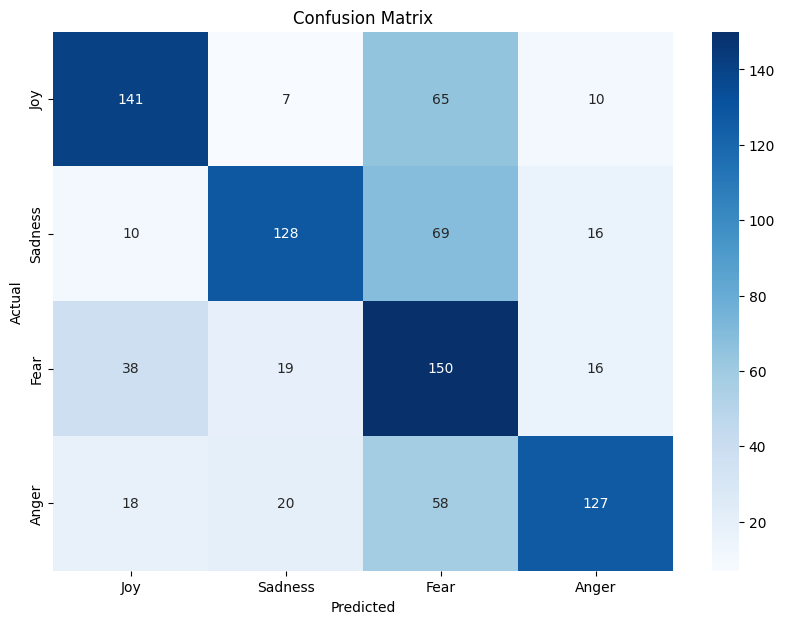

In [100]:
model_Evaluate(calibrated_rf_model,X_test)

### DEBIASED WORD EMBEDDING

In [45]:
import json
from gensim.models import Word2Vec
from debiaswe import we
from debiaswe.debias import debias,soft_debias
from debiaswe.we import WordEmbedding
from debiaswe.data import load_professions

### Prepare the Embedding Matrix for Debiasing

In [46]:
E = WordEmbedding('word2vec_embeddings.bin')

*** Reading data from word2vec_embeddings.bin
(251143, 100)
251143 words of dimension 100 : i, <, >, user, ..., 100pgs, sfv, blaiming, mrgans
251143 words of dimension 100 : i, <, >, user, ..., 100pgs, sfv, blaiming, mrgans


In [48]:
# Lets load some gender related word lists to help us with debiasing
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open('./data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself']]
gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


In [49]:
debias(E, gender_specific_words, defs, equalize_pairs)

251143 words of dimension 100 : i, <, >, user, ..., 100pgs, sfv, blaiming, mrgans
{('grandsons', 'granddaughters'), ('CATHOLIC_PRIEST', 'NUN'), ('wives', 'husbands'), ('Brothers', 'Sisters'), ('Uncle', 'Aunt'), ('gelding', 'mare'), ('Councilman', 'Councilwoman'), ('Ex_Girlfriend', 'Ex_Boyfriend'), ('Father', 'Mother'), ('TESTOSTERONE', 'ESTROGEN'), ('HIMSELF', 'HERSELF'), ('MAN', 'WOMAN'), ('nephew', 'niece'), ('GRANDFATHER', 'GRANDMOTHER'), ('Grandsons', 'Granddaughters'), ('HIS', 'HER'), ('CHAIRMAN', 'CHAIRWOMAN'), ('SONS', 'DAUGHTERS'), ('Catholic_Priest', 'Nun'), ('himself', 'herself'), ('COUNCILMAN', 'COUNCILWOMAN'), ('uncle', 'aunt'), ('father', 'mother'), ('FELLA', 'GRANNY'), ('Male', 'Female'), ('Boys', 'Girls'), ('Monastery', 'Convent'), ('Congressman', 'Congresswoman'), ('BROTHER', 'SISTER'), ('Grandson', 'Granddaughter'), ('males', 'females'), ('NEPHEW', 'NIECE'), ('Males', 'Females'), ('Brother', 'Sister'), ('king', 'queen'), ('he', 'she'), ('HE', 'SHE'), ('colt', 'filly'),

In [50]:
# Create a word-to-vector dictionary
word_to_vec_debiased = {word: vec for word, vec in zip(E.words, E.vecs)}

In [51]:
def get_sentence_embeddings(tokens, word_to_vec, vector_size):
    vectors = [word_to_vec[word] for word in tokens if word in word_to_vec]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [52]:
# Create embeddings for both training and test data
X_train_vectors_debiased = np.array([get_sentence_embeddings(tokens, word_to_vec_debiased, Embedding_dimensions) for tokens in Word2vec_train_data])
X_test_vectors_debiased = np.array([get_sentence_embeddings(tokens, word_to_vec_debiased, Embedding_dimensions) for tokens in Word2vec_test_data])

print("X_train_vectors_debiased shape:", X_train_vectors_debiased.shape)
print("X_test_vectors_debiased shape:", X_test_vectors_debiased.shape)

X_train_vectors_debiased shape: (1520000, 100)
X_test_vectors_debiased shape: (80000, 100)


In [53]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled_debiased = scaler.fit_transform(X_train_vectors_debiased)

# Only transform the test data (do not fit again)
X_test_scaled_debiased = scaler.transform(X_test_vectors_debiased )


In [54]:
# Initialize and train Naive Bayes model
nb_model_debiased = GaussianNB()
nb_model_debiased.fit(X_train_scaled_debiased, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test_scaled_debiased)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

Naive Bayes Accuracy: 0.6602


              precision    recall  f1-score   support

           0       0.64      0.74      0.69     39989
           1       0.69      0.58      0.63     40011

    accuracy                           0.66     80000
   macro avg       0.66      0.66      0.66     80000
weighted avg       0.66      0.66      0.66     80000



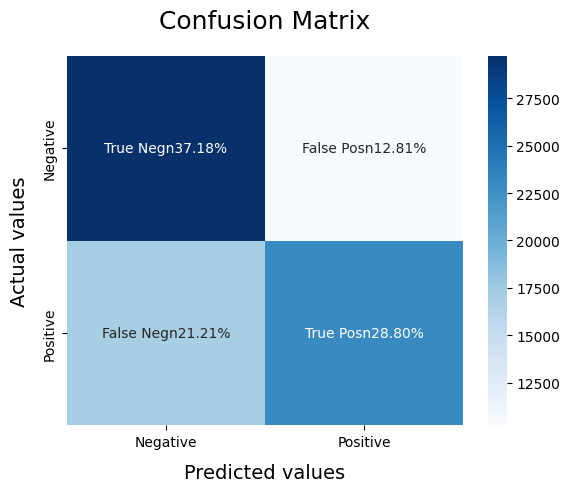

In [55]:
model_Evaluate(nb_model_debiased,X_test_scaled_debiased)

In [56]:
lr_model_debiased = LogisticRegression(solver='saga')  # or use solver='saga' for large datasets
lr_model_debiased.fit(X_train_scaled_debiased, y_train)

LogisticRegression(solver='saga')

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     39989
           1       0.76      0.77      0.76     40011

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000



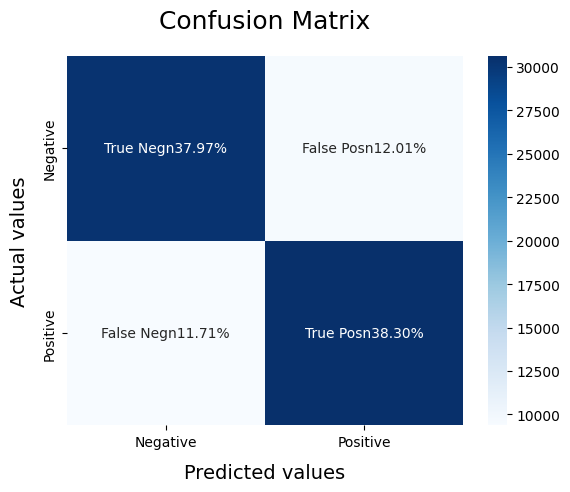

In [57]:
model_Evaluate(lr_model_debiased,X_test_scaled_debiased)

In [53]:
  # Linear SVM
linear_svc_model_debiased = LinearSVC()
linear_svc_model_debiased.fit(X_train_scaled_debiased, y_train)

C:\Users\Nivetha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Nivetha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     39989
           1       0.76      0.76      0.76     40011

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000



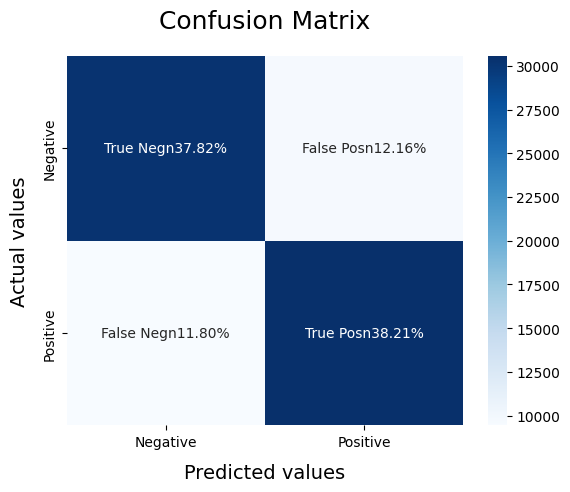

In [54]:
model_Evaluate(linear_svc_model_debiased,X_test_scaled_debiased)

### Saving the models

In [58]:
joblib.dump(lr_model_debiased, r'models\logistic_regression_debiasedmodel.pkl')
joblib.dump(nb_model_debiased, r'models\naive_bayes_debiasedmodel.pkl')

['models\\naive_bayes_debiasedmodel.pkl']

              precision    recall  f1-score   support

           0       0.64      0.74      0.69     39989
           1       0.69      0.58      0.63     40011

    accuracy                           0.66     80000
   macro avg       0.66      0.66      0.66     80000
weighted avg       0.66      0.66      0.66     80000



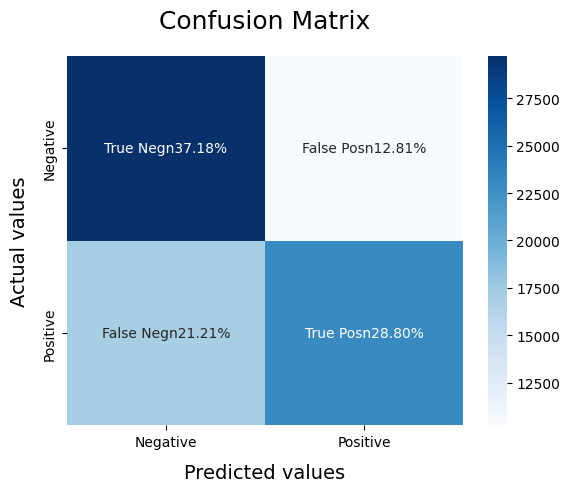

In [59]:
nb_model_debiased = joblib.load(r'models\naive_bayes_debiasedmodel.pkl')
model_Evaluate(nb_model_debiased,X_test_scaled_debiased)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     39989
           1       0.76      0.77      0.76     40011

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000



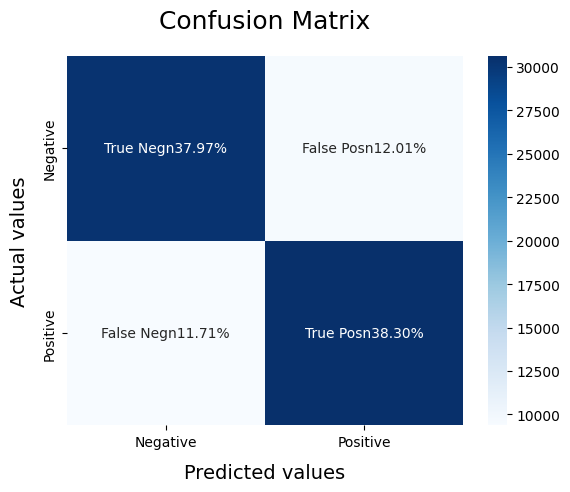

In [60]:
lr_model_debiased = joblib.load(r'models\logistic_regression_debiasedmodel.pkl')
model_Evaluate(lr_model_debiased,X_test_scaled_debiased)

 ## Soft Debiasing 

In [55]:
E_soft = WordEmbedding('word2vec_embeddings.bin')

*** Reading data from word2vec_embeddings.bin
(251143, 100)
251143 words of dimension 100 : i, <, >, user, ..., 100pgs, sfv, blaiming, mrgans
251143 words of dimension 100 : i, <, >, user, ..., 100pgs, sfv, blaiming, mrgans


In [56]:
soft_debias(E_soft, gender_specific_words, defs, equalize_pairs)

C:\Mini-Project\debiaswe\debias.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  Neutrals = torch.tensor([E.v(w) for w in gender_specific_words if w in E.index]).float().t()


Optimization Completed, normalizing vector transform
251143 words of dimension 100 : i, <, >, user, ..., 100pgs, sfv, blaiming, mrgans


In [57]:
# Create a word-to-vector dictionary
word_to_vec = {word: vec for word, vec in zip(E_soft.words, E_soft.vecs)}

In [58]:
# Create embeddings for both training and test data
X_train_vectors_softdebiased = np.array([get_sentence_embeddings(tokens, word_to_vec, Embedding_dimensions) for tokens in Word2vec_train_data])
X_test_vectors_softdebiased = np.array([get_sentence_embeddings(tokens, word_to_vec, Embedding_dimensions) for tokens in Word2vec_test_data])

print("X_train_vectors_debiased shape:", X_train_vectors_softdebiased.shape)
print("X_test_vectors_debiased shape:", X_test_vectors_softdebiased.shape)

X_train_vectors_debiased shape: (1520000, 100)
X_test_vectors_debiased shape: (80000, 100)


In [59]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled_softdebiased = scaler.fit_transform(X_train_vectors_softdebiased)

# Only transform the test data (do not fit again)
X_test_scaled_softdebiased = scaler.transform(X_test_vectors_softdebiased )

In [60]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize and train Naive Bayes model
nb_model_softdebiased = GaussianNB()
nb_model_softdebiased.fit(X_train_scaled_softdebiased, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test_scaled_softdebiased)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

Naive Bayes Accuracy: 0.5133


              precision    recall  f1-score   support

           0       0.53      0.25      0.34     39989
           1       0.51      0.77      0.61     40011

    accuracy                           0.51     80000
   macro avg       0.52      0.51      0.48     80000
weighted avg       0.52      0.51      0.48     80000



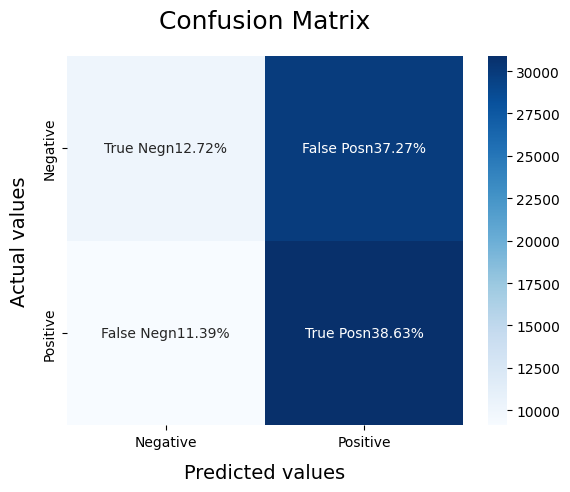

In [61]:
model_Evaluate(nb_model_softdebiased,X_test_scaled_softdebiased)

In [65]:
  # Linear SVM
linear_svc_model_softdebiased = LinearSVC()
linear_svc_model_softdebiased.fit(X_train_scaled_softdebiased, y_train)

C:\Users\Nivetha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Nivetha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

              precision    recall  f1-score   support

           0       0.61      0.57      0.59     39989
           1       0.60      0.63      0.62     40011

    accuracy                           0.60     80000
   macro avg       0.60      0.60      0.60     80000
weighted avg       0.60      0.60      0.60     80000



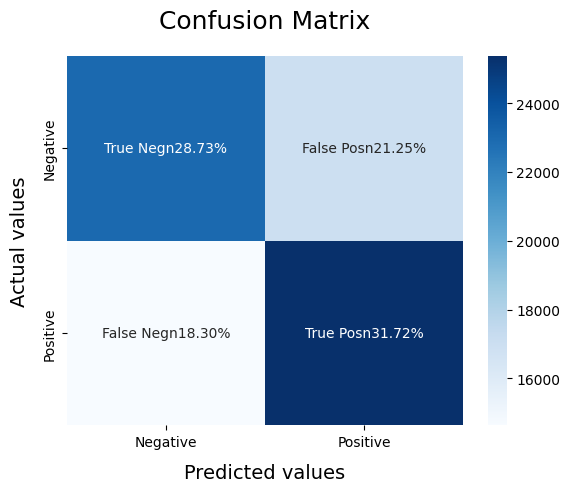

In [66]:
model_Evaluate(linear_svc_model_softdebiased,X_test_scaled_softdebiased)

In [62]:
lr_model_softdebiased = LogisticRegression(solver='saga')  
lr_model_softdebiased.fit(X_train_scaled_softdebiased, y_train)

LogisticRegression(solver='saga')

              precision    recall  f1-score   support

           0       0.52      0.43      0.47     39989
           1       0.52      0.61      0.56     40011

    accuracy                           0.52     80000
   macro avg       0.52      0.52      0.51     80000
weighted avg       0.52      0.52      0.51     80000



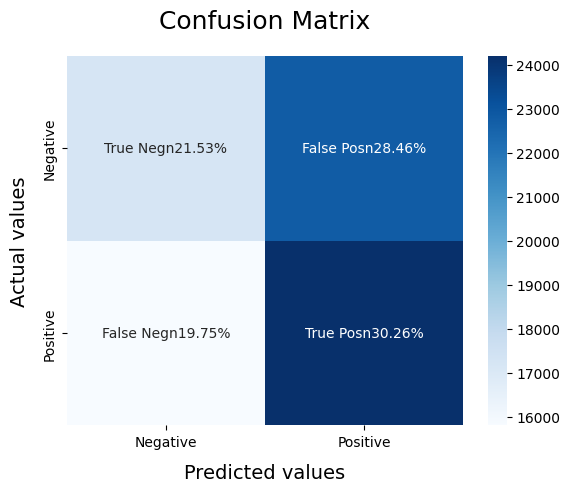

In [64]:
model_Evaluate(lr_model_softdebiased,X_test_scaled_softdebiased)